In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score

# 3. Модели
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import cross_val_predict

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import confusion_matrix

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [2]:
%matplotlib inline

In [3]:
matplotlib.rcParams.update({'font.size': 12})  # размер шрифта на графиках

<H3> Загрузка данных

In [4]:
DATASET_PATH = './prepared.csv'


df = pd.read_csv(DATASET_PATH, sep=';')

In [5]:
df.head(3)

,Физическое лицо,Подразделение,Должность,Причина увольнения,Первая дата приема,Последняя дата приема,Последняя дата увольнения,Медиана между приемами,Длительность последнего рейса,Кол-во рейсов,...,город,населенный пункт,столица,Командный состав,Обслуживающий,Производство,Судовая команда,активная,нейтральная,пассивная
0,Ёркина Виктория Александровна,ЮМРФ_Залив Восток ПЗ,Матрос 2 класса службы обработки рыбы,"Истечение срока трудового договора, п2 ч1 ст77",2020-03-27,2020-03-27,2020-09-10,0.0,167.0,1,...,1,0,0,0,0,1,0,0,1,0
1,АЛИ ИМРОН,ЮМРФ_Всеволод Сибирцев КРКПБ,Обработчик рыбы,"Истечение срока трудового договора, п2 ч1 ст77",2016-05-30,2016-05-30,2017-04-17,0.0,322.0,1,...,1,0,0,0,0,1,0,0,1,0
2,Абаев Дмитрий Анатольевич,ЮМРФ_Залив Восток ПЗ,Матрос-обработчик,"Истечение срока трудового договора, п2 ч1 ст77",2015-06-22,2015-06-22,2015-08-26,0.0,65.0,1,...,0,1,0,0,0,1,0,0,1,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6124 entries, 0 to 6123
Data columns (total 38 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Физическое лицо                6124 non-null   object 
 1   Подразделение                  6124 non-null   object 
 2   Должность                      6124 non-null   object 
 3   Причина увольнения             5870 non-null   object 
 4   Первая дата приема             6124 non-null   object 
 5   Последняя дата приема          6124 non-null   object 
 6   Последняя дата увольнения      6124 non-null   object 
 7   Медиана между приемами         6124 non-null   float64
 8   Длительность последнего рейса  6124 non-null   float64
 9   Кол-во рейсов                  6124 non-null   int64  
 10  Возраст                        6124 non-null   int64  
 11  Target                         6124 non-null   int64  
 12  женский                        6124 non-null   i

In [7]:
df['Target'].value_counts()

0    3872
1    2252
Name: Target, dtype: int64

<h2> Разбиение на train / test 

In [8]:
X = df.drop(columns='Target')
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)
X_train.index

Int64Index([3118, 1841,  919, 4596, 2690, 4052, 1800, 5295, 4242, 2126,
            ...
            5698, 4149, 1890, 6068,  350, 6026,   79, 3927, 5955, 5640],
           dtype='int64', length=4103)

In [9]:
y_train.value_counts()

0    2608
1    1495
Name: Target, dtype: int64

In [10]:
y_test.value_counts()

0    1264
1     757
Name: Target, dtype: int64

**Оставим признаки, которые необходимы для модели**

In [11]:
X_train.columns.tolist()

['Физическое лицо',
 'Подразделение',
 'Должность',
 'Причина увольнения',
 'Первая дата приема',
 'Последняя дата приема',
 'Последняя дата увольнения',
 'Медиана между приемами',
 'Длительность последнего рейса',
 'Кол-во рейсов',
 'Возраст',
 'женский',
 'мужской',
 'добывающее судно',
 'плавбаза',
 'траспортное',
 'Беларусь',
 'ДВФО',
 'Индонезия',
 'ПФО',
 'СЗФО',
 'СКФО',
 'СФО',
 'УФО',
 'Украина',
 'ЦФО',
 'ЮФО',
 'город',
 'населенный пункт',
 'столица',
 'Командный состав',
 'Обслуживающий',
 'Производство',
 'Судовая команда',
 'активная',
 'нейтральная',
 'пассивная']

In [12]:
feature_names = [#'Медиана между приемами',
     'Длительность последнего рейса',
     'Возраст',
     'город', 'населенный пункт', 'столица',
     'женский',
     'мужской',
     'добывающее судно',
     'плавбаза',
     'траспортное',
     #'Беларусь',
     #'ДВФО',
     #'ПФО',
     #'СЗФО',
     #'СКФО',
     #'СФО',
     #'УФО',
     #'Украина',
     #'ЦФО',
     #'ЮФО',
     'Командный состав',
     'Обслуживающий',
     'Производство',
     'Судовая команда',
     'активная',
     'нейтральная',
     'пассивная']

target_name = 'Target'

In [13]:
X_train = X_train[feature_names]
X_test = X_test[feature_names]

X_train.head()

,Длительность последнего рейса,Возраст,город,населенный пункт,столица,женский,мужской,добывающее судно,плавбаза,траспортное,Командный состав,Обслуживающий,Производство,Судовая команда,активная,нейтральная,пассивная
3118,232.0,42,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1841,6.0,45,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1
919,213.0,23,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0
4596,132.0,33,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1
2690,12.0,43,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1


**Стандартизация признаков** 

In [14]:
feature_names_for_stand = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
feature_names_for_stand

['Длительность последнего рейса',
 'Возраст',
 'город',
 'населенный пункт',
 'столица',
 'женский',
 'мужской',
 'добывающее судно',
 'плавбаза',
 'траспортное',
 'Командный состав',
 'Обслуживающий',
 'Производство',
 'Судовая команда',
 'активная',
 'нейтральная',
 'пассивная']

**Нормализация** - MinMaxScaler() Для каждой фичи x делает:
$$\frac{x_i - min}{max - min}$$
После нормализации признак будет изменяться в диапазоне [0, 1].<br>
Лучше зарекомендовала себя в моделях, которые работают с расстояниями (KNN).

<br>

**Стандартизация** - StandardScaler(). Для каждой фичи х делает:
$$\frac{x - mean}{std}$$
После стандартизации у признака будут mean = 0, std = 1.<br>
Лучше зарекомендовала себя в линейных моделях.

In [15]:
scaler = StandardScaler()

stand_features_train = scaler.fit_transform(X_train[feature_names_for_stand])
stand_features_test = scaler.transform(X_test[feature_names_for_stand])

In [16]:
stand_features_train

array([[ 0.24601231, -0.03235257,  1.19792105, ..., -0.59320702,
        -1.30974053,  2.87434358],
       [-0.94835517,  0.20943721, -0.83477956, ..., -0.59320702,
        -1.30974053,  2.87434358],
       [ 0.14560088, -1.56368781,  1.19792105, ..., -0.59320702,
         0.76351001, -0.34790552],
       ...,
       [ 0.11389201, -1.48309122,  1.19792105, ..., -0.59320702,
         0.76351001, -0.34790552],
       [-0.34060181, -0.27414234, -0.83477956, ..., -0.59320702,
         0.76351001, -0.34790552],
       [-0.89550705,  1.33778949,  1.19792105, ..., -0.59320702,
        -1.30974053,  2.87434358]])

In [17]:
X_train[feature_names_for_stand] = stand_features_train
X_test[feature_names_for_stand] = stand_features_test

In [18]:
X_train.head()

,Длительность последнего рейса,Возраст,город,населенный пункт,столица,женский,мужской,добывающее судно,плавбаза,траспортное,Командный состав,Обслуживающий,Производство,Судовая команда,активная,нейтральная,пассивная
3118,0.246012,-0.032353,1.197921,-0.775151,-0.521774,2.444973,-2.444973,-0.692935,0.976632,-0.442562,-0.497485,-0.219746,1.030944,-0.609363,-0.593207,-1.309741,2.874344
1841,-0.948355,0.209437,-0.834780,1.290072,-0.521774,-0.409003,0.409003,1.443137,-1.023927,-0.442562,-0.497485,4.550714,-0.969985,-0.609363,-0.593207,-1.309741,2.874344
919,0.145601,-1.563688,1.197921,-0.775151,-0.521774,-0.409003,0.409003,1.443137,-1.023927,-0.442562,2.010110,-0.219746,-0.969985,-0.609363,-0.593207,0.763510,-0.347906
4596,-0.282469,-0.757722,1.197921,-0.775151,-0.521774,-0.409003,0.409003,-0.692935,0.976632,-0.442562,-0.497485,-0.219746,1.030944,-0.609363,-0.593207,-1.309741,2.874344
2690,-0.916646,0.048244,-0.834780,-0.775151,1.916539,-0.409003,0.409003,-0.692935,0.976632,-0.442562,-0.497485,-0.219746,1.030944,-0.609363,-0.593207,-1.309741,2.874344


# Построение моделей <a class='anchor' id='model'>

    
ML метрика - Mean Squared Error (**MSE**) 
    - MSE прямопропорциональна RMSE и R^2
    - MSE  удобно оптимизировать (брать производные)
    - MSE используется "под капотом" наших ML моделей



Бизнес метрика - **R^2**, Root Mean Squared Error (**RMSE**)
    - Бизнес метрика интерпретируема
    - Понятна бизнесу
    - Ее мы показываем бизнесу
    - RMSE - насколько, в среднем, $ мы ошибаемся при предсказании цен 
    - R^2 принимает значения от 0 до 1, если 1 - все предсказания идеальны. Можно сказать, что это "точность" модели

Лучшая модель - модель с наименьшей MSE на test 

In [19]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )

Дерево решений

In [20]:
dt_model = DecisionTreeClassifier(criterion = 'entropy', 
                                 max_depth = 3, # глубина дерева  
                                 #min_samples_split = 20, # минимальное кол-во наблюдений в листе дерева
                                 #min_samples_leaf = 20,
                                 max_features = 5,
                                 random_state = 42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, max_features=5,
                       random_state=42)

In [21]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)


R2:	-0.599
RMSE:	0.612
MSE:	0.375


In [22]:
#y_train_preds = cross_val_predict(dt_model, X_train, y_train, cv=3)
y_train_preds = dt_model.predict(X_train)
print(confusion_matrix(y_train, y_train_preds))

[[2608    0]
 [1495    0]]


In [23]:
y_test_preds = cross_val_predict(dt_model, X_test, y_test, cv=3)
print(confusion_matrix(y_test, y_test_preds))

[[1199   65]
 [ 706   51]]


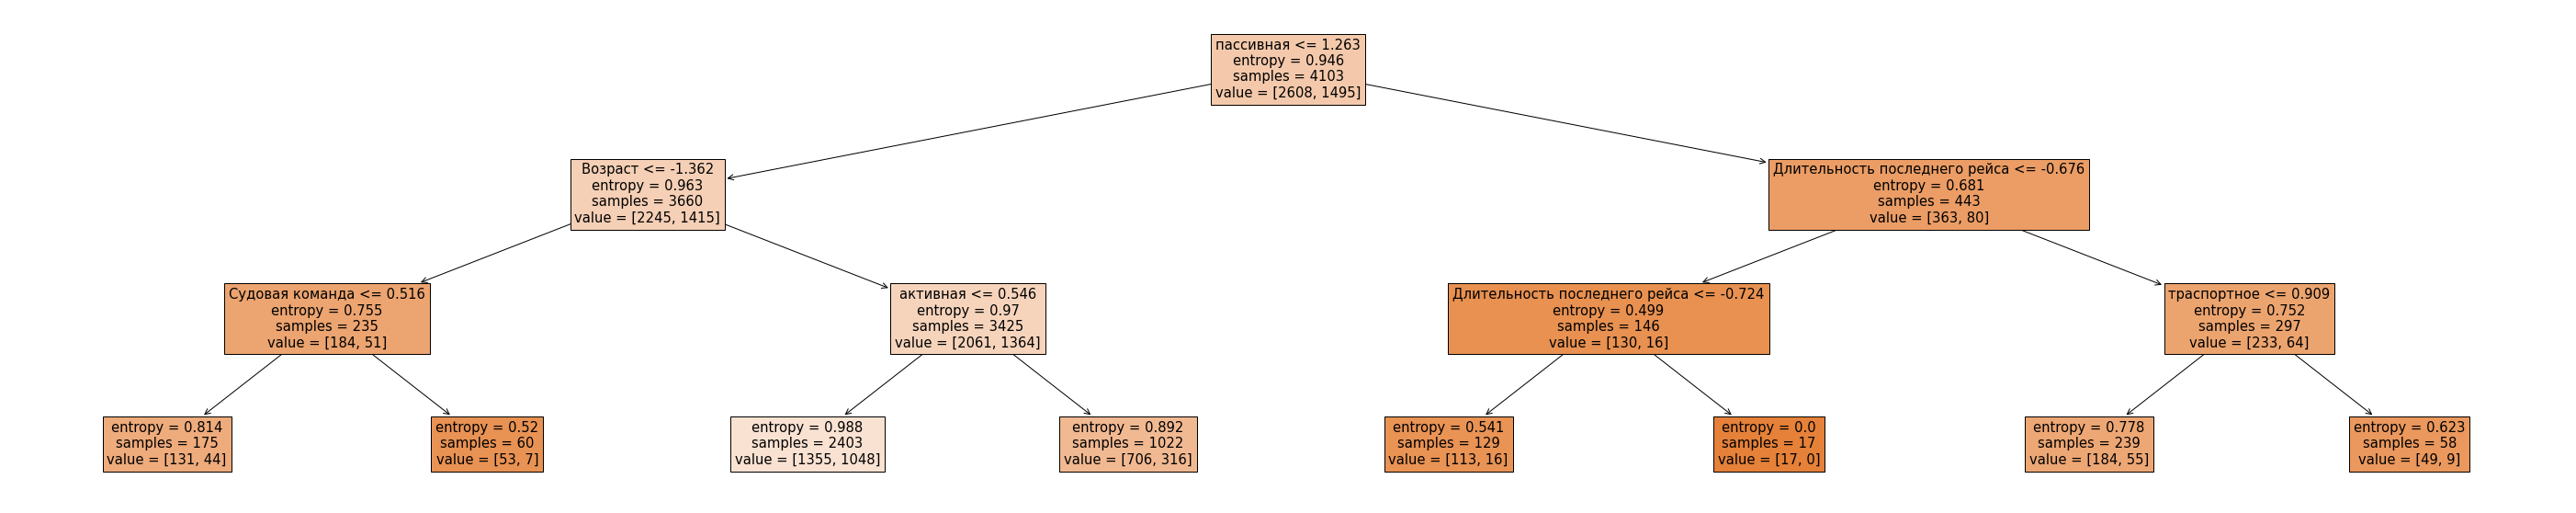

In [24]:
plt.figure(figsize=(50, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True);

#plt.savefig('destination_path.eps', format='eps', dpi=1000) 

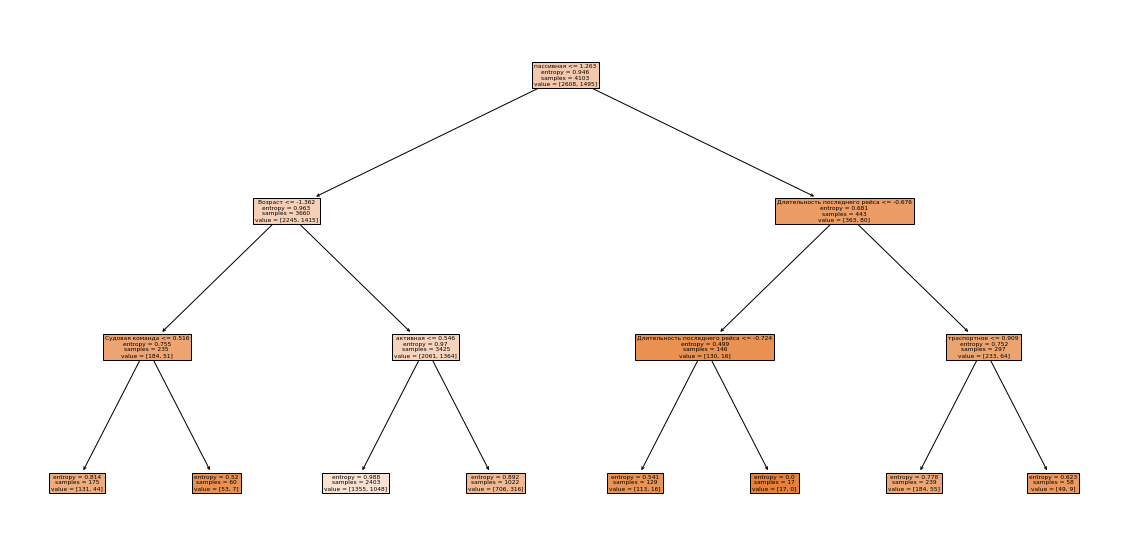

In [86]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True, max_depth=3);

In [95]:
dt_model.feature_importances_

array([0.06724072, 0.18172519, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00909882,
       0.        , 0.        , 0.        , 0.02912584, 0.2716669 ,
       0.        , 0.44114253])

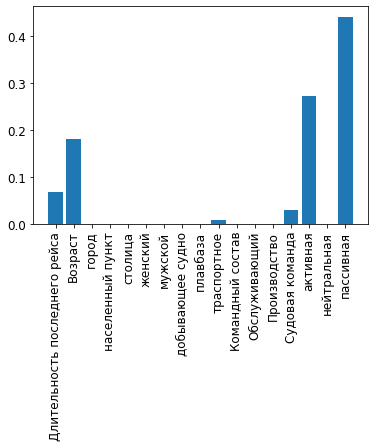

In [89]:
index = feature_names_for_stand
values = dt_model.feature_importances_
plt.bar(index,values)
plt.xticks(rotation=90)
plt.show()

In [144]:
rf_model = RandomForestClassifier(n_estimators=1, 
                                  criterion='gini', 
                                  max_depth=5, 
                                  min_samples_split=2, 
                                  min_samples_leaf=3, 
                                  min_weight_fraction_leaf=0.0, 
                                  max_features=3, 
                                  max_leaf_nodes=None, 
                                  bootstrap=True, 
                                  oob_score=False, 
                                  n_jobs=3, 
                                  random_state=None, 
                                  verbose=0, 
                                  warm_start=False, 
                                  class_weight=None)

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	-0.542
RMSE:	0.598
MSE:	0.357


In [145]:
#y_train_preds = cross_val_predict(dt_model, X_train, y_train, cv=3)
y_train_preds = rf_model.predict(X_train)
print(confusion_matrix(y_train, y_train_preds))

[[2526   82]
 [1383  112]]


In [146]:
y_test_preds = cross_val_predict(rf_model, X_test, y_test, cv=3)
print(confusion_matrix(y_test, y_test_preds))

[[906 358]
 [518 239]]


In [147]:
rf_model.feature_importances_

array([0.10756771, 0.17495088, 0.01620602, 0.05164848, 0.02758142,
       0.0005934 , 0.00587591, 0.        , 0.025087  , 0.008884  ,
       0.01856686, 0.        , 0.        , 0.        , 0.136578  ,
       0.16221701, 0.26424331])

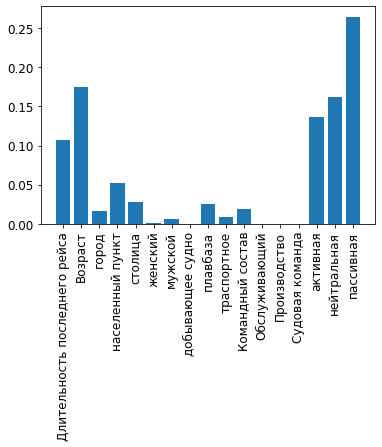

In [148]:
index = feature_names_for_stand
values = rf_model.feature_importances_
plt.bar(index,values)
plt.xticks(rotation=90)
plt.show()

In [155]:
clf = GradientBoostingClassifier(n_estimators=2, 
                                 learning_rate=1.0,
                                 max_depth=3, 
                                 random_state=42)

clf.fit(X_train, y_train)
y_train_preds = clf.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	-0.529
RMSE:	0.595
MSE:	0.354


In [156]:
#y_train_preds = cross_val_predict(dt_model, X_train, y_train, cv=3)
y_train_preds = clf.predict(X_train)
print(confusion_matrix(y_train, y_train_preds))

[[2573   35]
 [1418   77]]


In [157]:
y_test_preds = cross_val_predict(clf, X_test, y_test, cv=3)
print(confusion_matrix(y_test, y_test_preds))

[[1130  134]
 [ 635  122]]


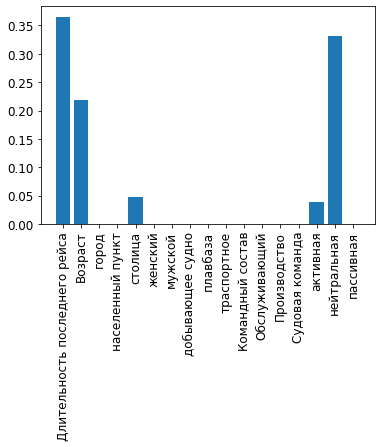

In [158]:
index = feature_names_for_stand
values = clf.feature_importances_
plt.bar(index,values)
plt.xticks(rotation=90)
plt.show()